# Predicting the Super Bowl 2022 Winner

## 3. Data Pre-processing

In [1]:
# Import relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.cluster import KMeans

In [2]:
# Import data

team_stats = pd.read_csv('SuperBowl_EDA.csv')
team_stats.head(3)

,Date,Week,Start_Time,Overtime,Team,Home_game,Opponent,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers,Score
0,2021-09-12,1,13:00:00,0.0,Buffalo Bills,1.0,Pittsburgh Steelers,22,371,117,1,16,252,75,0,16
1,2021-09-19,2,13:00:00,0.0,Buffalo Bills,0.0,Miami Dolphins,21,314,143,2,13,223,71,3,35
2,2021-09-26,3,13:00:00,0.0,Buffalo Bills,1.0,Washington Football Team,29,481,122,0,13,290,78,3,43


Our target is to predict the score of Los Angeles Rams vs Cincinnati Bengals game. The points scored by a team depend on the listed features. However, we don't know the values of *1st_downs*, *Total_yards*, *Rushing_yards*, and *Turnovers* for both teams. Thus, the prediction model will involve three steps:

1. Estimate performance statistics of the two team playing Super Bowl 2022.

2. Develop a regression model that accurately determines the scores from previous games played in the season.

3. Input the estimated feature values in the model to predict the score for each team.

## 3.1. Estimate teams' performance statistics

The Los Angeles Rams and Cincinnati Bengals did not play against each other during the regular season. Thus, we will have to estimate how much yards and points their offense will gain and how much of yards and points their defense will allow. We can do this by analyzing the performance of each of their opponents. E.g, in the case of Rams, we will find the opponent teams that have performance metrics closest to those of the Bengals in their last three games.

This can be done using clustering analysis. We will classify the Rams' opponents into several clusters. Then, we will calculate the average performance of the Bengals in their last three games as 'test data'. This data will be labeled using the cluster model. We will consider the teams that have the same label as 'test' data for further analysis.

### 3.1.1. Los Angeles Rams performance estimation

In [3]:
# Select the features for clustering of the Rams' opponents

team_stats_LAR = team_stats[team_stats.Team == 'Los Angeles Rams'].loc[:,'Opponent':'Opp_Turnovers']

# Drop the last row that corresponds to Super Bowl

team_stats_LAR = team_stats_LAR.iloc[:-1,:]
team_stats_LAR.head(3)

,Opponent,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers
494,Chicago Bears,18,386,74,0,24,322,134,2
495,Indianapolis Colts,21,371,101,2,22,354,109,2
496,Tampa Bay Buccaneers,22,407,76,0,27,446,35,0


In [4]:
# Standardize the selected data

scaler = StandardScaler()
LAR_scaled = scaler.fit_transform(team_stats_LAR.drop(columns='Opponent'))

In [5]:
# Determine the optimal number of clusters

ssd = []

for c in range(1,len(LAR_scaled)):
    kmeans = KMeans(n_clusters=c, random_state=42)
    kmeans.fit(LAR_scaled)
    ssd.append(kmeans.inertia_)

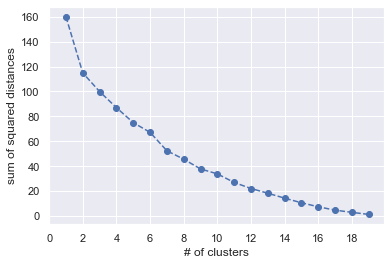

In [6]:
plt.figure()
plt.plot(range(1,len(LAR_scaled)),ssd, marker='o', linestyle='--')
plt.xlabel('# of clusters')
plt.ylabel('sum of squared distances')
plt.xticks(range(0,len(LAR_scaled),2))
plt.show();

We will classify the opponents in 7 clusters.

In [7]:
kmeans = KMeans(n_clusters=7,random_state=42)
kmeans.fit(LAR_scaled)

KMeans(n_clusters=7, random_state=42)

In [8]:
# Assign cluster labels to Rams' opponents

team_stats_LAR['Label'] = kmeans.labels_
team_stats_LAR

,Opponent,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers,Label
494,Chicago Bears,18,386,74,0,24,322,134,2,1
495,Indianapolis Colts,21,371,101,2,22,354,109,2,2
496,Tampa Bay Buccaneers,22,407,76,0,27,446,35,0,6
497,Arizona Cardinals,24,401,121,2,27,465,216,0,5
498,Seattle Seahawks,24,476,118,1,22,354,92,2,2
499,New York Giants,22,365,131,2,21,261,60,4,2
500,Detroit Lions,22,374,47,0,19,415,137,2,1
501,Houston Texans,26,467,165,0,18,323,44,1,4
502,Tennessee Titans,22,347,94,2,16,194,69,1,0
503,San Francisco 49ers,16,278,52,2,20,335,156,0,3


In [9]:
# Calculate Bengals' average performance over the last three games
# Discard the last row that corresponds to Super Bowl

CIN_as_Opp = team_stats[team_stats.Team == 'Cincinnati Bengals'].loc[:,'1st_downs':'Opp_Turnovers'].iloc[-4:-1,:]
CIN_as_Opp

,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers
157,18,308,83,0,23,385,103,2
158,17,345,65,1,16,353,140,3
159,21,359,116,1,24,375,139,2


We need to keep in mind that we are considering the Bengals as the Rams' opponent. Thus, Bengals' offensive performance is equivalent to Rams' defensive performance and vice versa. We can reformat the above data frame so that it is consistent with Rams' performance data.

In [10]:
# Rearrange the data

CIN_as_Opp.columns

Index(['1st_downs', 'Total_yards', 'Rushing_yards', 'Turnovers',
       'Opp_1st_downs', 'Opp_Total_yards', 'Opp_Rushing_yards',
       'Opp_Turnovers'],
      dtype='object')

In [11]:
col_list = ['Opp_1st_downs', 'Opp_Total_yards', 'Opp_Rushing_yards','Opp_Turnovers','1st_downs', 'Total_yards', 'Rushing_yards',
            'Turnovers']
CIN_as_Opp = CIN_as_Opp[col_list]

In [12]:
# Change the columne titles

CIN_as_Opp.columns = ['1st_downs', 'Total_yards', 'Rushing_yards', 'Turnovers','Opp_1st_downs', 'Opp_Total_yards', 
                         'Opp_Rushing_yards', 'Opp_Turnovers']
CIN_as_Opp

,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers
157,23,385,103,2,18,308,83,0
158,16,353,140,3,17,345,65,1
159,24,375,139,2,21,359,116,1


In [13]:
# Calculate average performance metrics

CIN_as_Opp_stats = CIN_as_Opp.mean(axis=0)
CIN_as_Opp_y = CIN_as_Opp_stats.to_numpy().reshape(1,-1)
CIN_as_Opp_y

array([[ 21.        , 371.        , 127.33333333,   2.33333333,
         18.66666667, 337.33333333,  88.        ,   0.66666667]])

In [14]:
# Use the clustering model to predict the label of CIN_y data

CIN_as_Opp_label = kmeans.predict(CIN_as_Opp_y)
CIN_as_Opp_label

array([5])

In [15]:
# Find Rams' opponents with label = 5

closest_match_LAR = team_stats_LAR[team_stats_LAR.Label == 6]
closest_match_LAR

,Opponent,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers,Label
496,Tampa Bay Buccaneers,22,407,76,0,27,446,35,0,6


**The Bengals' performance in the last three games is closest to the Tampa Bay Buccaneers' performance against the Rams.**

In [16]:
# Add the closest match to recent three performances of the Bengals

CIN_as_Opp = CIN_as_Opp.append(closest_match_LAR.drop(columns=['Opponent','Label']))
CIN_as_Opp

,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers
157,23,385,103,2,18,308,83,0
158,16,353,140,3,17,345,65,1
159,24,375,139,2,21,359,116,1
496,22,407,76,0,27,446,35,0


In [17]:
# We will input the average of CIN_as_Opp values in the regression model to predict score

LAR_performance = CIN_as_Opp.mean(axis=0)
LAR_performance

1st_downs             21.25
Total_yards          380.00
Rushing_yards        114.50
Turnovers              1.75
Opp_1st_downs         20.75
Opp_Total_yards      364.50
Opp_Rushing_yards     74.75
Opp_Turnovers          0.50
dtype: float64

### 3.1.2. Cincinnati Bengals performance estimation

In [18]:
# Select the features for clustering of the Bengals' opponents

team_stats_CIN = team_stats[team_stats.Team == 'Cincinnati Bengals'].loc[:,'Opponent':'Opp_Turnovers']

# Drop the last row that corresponds to Super Bowl

team_stats_CIN = team_stats_CIN.iloc[:-1,:]
team_stats_CIN.head(3)

,Opponent,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers
140,Minnesota Vikings,20,366,149,0,24,403,67,1
141,Chicago Bears,14,248,69,4,16,206,123,1
142,Pittsburgh Steelers,12,268,96,1,21,342,45,2


In [19]:
# Standardize the selected data

scaler = StandardScaler()
CIN_scaled = scaler.fit_transform(team_stats_CIN.drop(columns='Opponent'))

In [20]:
# Determine the optimal number of clusters

ssd = []

for c in range(1,len(CIN_scaled)):
    kmeans = KMeans(n_clusters=c, random_state=42)
    kmeans.fit(CIN_scaled)
    ssd.append(kmeans.inertia_)

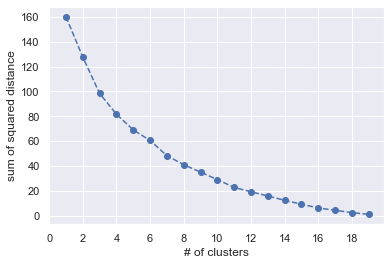

In [21]:
plt.figure()
plt.plot(range(1,len(CIN_scaled)),ssd, marker='o', linestyle='--')
plt.xlabel('# of clusters')
plt.ylabel('sum of squared distance')
plt.xticks(range(0,len(CIN_scaled),2))
plt.show();

Optimal number of cluster = 8

In [22]:
kmeans = KMeans(n_clusters=8,random_state=42)
kmeans.fit(CIN_scaled)

KMeans(random_state=42)

In [23]:
# Assign cluster labels to Bengals' opponents

team_stats_CIN['Label'] = kmeans.labels_
team_stats_CIN

,Opponent,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers,Label
140,Minnesota Vikings,20,366,149,0,24,403,67,1,3
141,Chicago Bears,14,248,69,4,16,206,123,1,5
142,Pittsburgh Steelers,12,268,96,1,21,342,45,2,6
143,Jacksonville Jaguars,21,420,78,0,21,341,139,0,2
144,Green Bay Packers,18,367,103,2,21,466,133,1,3
145,Detroit Lions,20,398,142,1,15,228,36,1,0
146,Baltimore Ravens,19,520,111,1,20,393,115,0,2
147,New York Jets,18,318,41,1,32,511,97,3,7
148,Cleveland Browns,25,348,85,3,14,361,153,0,5
149,Las Vegas Raiders,23,288,159,1,13,278,72,2,0


In [24]:
# Calculate Rams' average performance over the last three games
# Discard the last row that corresponds to Super Bowl

LAR_as_Opp = team_stats[team_stats.Team == 'Los Angeles Rams'].loc[:,'1st_downs':'Opp_Turnovers'].iloc[-4:-1,:]
LAR_as_Opp

,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers
511,16,375,140,0,14,183,61,2
512,24,428,73,4,20,359,51,2
513,25,396,70,1,16,282,50,1


In [25]:
# Rearrange the data

LAR_as_Opp = LAR_as_Opp[col_list]

In [26]:
# Change the columne titles

LAR_as_Opp.columns = ['1st_downs', 'Total_yards', 'Rushing_yards', 'Turnovers','Opp_1st_downs', 'Opp_Total_yards', 
                         'Opp_Rushing_yards', 'Opp_Turnovers']
LAR_as_Opp

,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers
511,14,183,61,2,16,375,140,0
512,20,359,51,2,24,428,73,4
513,16,282,50,1,25,396,70,1


In [27]:
# Calculate average performance metrics

LAR_as_Opp_stats = LAR_as_Opp.mean(axis=0)
LAR_as_Opp_y = LAR_as_Opp_stats.to_numpy().reshape(1,-1)
LAR_as_Opp_y

array([[ 16.66666667, 274.66666667,  54.        ,   1.66666667,
         21.66666667, 399.66666667,  94.33333333,   1.66666667]])

In [28]:
# Predict the label for target performance

LAR_as_Opp_label = kmeans.predict(LAR_as_Opp_y)
LAR_as_Opp_label

array([7])

In [29]:
# Find Bengals' opponents with label = 7

closest_match_CIN = team_stats_CIN[team_stats_CIN.Label == 7]
closest_match_CIN

,Opponent,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers,Label
147,New York Jets,18,318,41,1,32,511,97,3,7


**The Rams' performance in the last three games is closest to the New York Jets' performance against the Bengals.**

In [30]:
# Add the closest match to recent three performances of the Rams

LAR_as_Opp = LAR_as_Opp.append(closest_match_CIN.drop(columns=['Opponent','Label']))
LAR_as_Opp

,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers
511,14,183,61,2,16,375,140,0
512,20,359,51,2,24,428,73,4
513,16,282,50,1,25,396,70,1
147,18,318,41,1,32,511,97,3


In [31]:
# Take the average of LAR_as_Opp. We will use this as the Bengals' predicted performance in the Super Bowl

CIN_performance = LAR_as_Opp.mean(axis=0)
CIN_performance

1st_downs             17.00
Total_yards          285.50
Rushing_yards         50.75
Turnovers              1.50
Opp_1st_downs         24.25
Opp_Total_yards      427.50
Opp_Rushing_yards     95.00
Opp_Turnovers          2.00
dtype: float64

## 3.2. Develop a regression model to predict scores

### 3.2.1. Data pre-processing

In [32]:
# Drop 'Opponent' column as it is not useful in regression analysis

team_stats_reg = team_stats.drop(columns='Opponent')

In [33]:
# Create dummy variables for team names

team_names = pd.get_dummies(team_stats_reg['Team'])
team_names.head(3)

,Arizona Cardinals,Atlanta Falcons,Baltimore Ravens,Buffalo Bills,Carolina Panthers,Chicago Bears,Cincinnati Bengals,Cleveland Browns,Dallas Cowboys,Denver Broncos,...,New Orleans Saints,New York Giants,New York Jets,Philadelphia Eagles,Pittsburgh Steelers,San Francisco 49ers,Seattle Seahawks,Tampa Bay Buccaneers,Tennessee Titans,Washington Football Team
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Remove 'Team' feature from the data frame and append dummy variables instead.
# Remove 'Date' since it's nearly identical in trend with 'Week'.
# Also remove 'Start_Time' since no other game except Super Bowl starts at 6.30 pm.

team_stats_reg = team_stats_reg.drop(columns=['Team','Date','Start_Time'])
team_stats_reg[3:] = team_stats_reg[3:].astype(float)
team_stats_reg = pd.concat([team_stats_reg,team_names], axis=1)
team_stats_reg.head(3)

,Week,Overtime,Home_game,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,...,New Orleans Saints,New York Giants,New York Jets,Philadelphia Eagles,Pittsburgh Steelers,San Francisco 49ers,Seattle Seahawks,Tampa Bay Buccaneers,Tennessee Titans,Washington Football Team
0,1.0,0.0,1.0,22.0,371.0,117.0,1.0,16.0,252.0,75.0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,0.0,0.0,21.0,314.0,143.0,2.0,13.0,223.0,71.0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,0.0,1.0,29.0,481.0,122.0,0.0,13.0,290.0,78.0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Sort the data by 'Week'

team_stats_reg = team_stats_reg.sort_values(by='Week', axis=0)
team_stats_reg[team_stats_reg.Week == 1]

,Week,Overtime,Home_game,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,...,New Orleans Saints,New York Giants,New York Jets,Philadelphia Eagles,Pittsburgh Steelers,San Francisco 49ers,Seattle Seahawks,Tampa Bay Buccaneers,Tennessee Titans,Washington Football Team
0,1.0,0.0,1.0,22.0,371.0,117.0,1.0,16.0,252.0,75.0,...,0,0,0,0,0,0,0,0,0,0
71,1.0,0.0,1.0,17.0,248.0,86.0,3.0,22.0,416.0,136.0,...,0,0,0,0,0,0,0,0,1,0
89,1.0,0.0,1.0,23.0,336.0,113.0,1.0,18.0,381.0,140.0,...,0,0,0,0,0,0,0,0,0,0
106,1.0,0.0,1.0,22.0,449.0,160.0,0.0,20.0,395.0,76.0,...,0,0,0,0,0,0,0,0,0,0
123,1.0,0.0,0.0,20.0,395.0,76.0,3.0,22.0,449.0,160.0,...,0,0,0,0,0,0,0,0,0,0
140,1.0,1.0,1.0,20.0,366.0,149.0,0.0,24.0,403.0,67.0,...,0,0,0,0,0,0,0,0,0,0
553,1.0,0.0,0.0,18.0,381.0,140.0,1.0,23.0,336.0,113.0,...,0,0,0,0,0,0,1,0,0,0
161,1.0,0.0,0.0,16.0,252.0,75.0,0.0,22.0,371.0,117.0,...,0,0,0,0,1,0,0,0,0,0
179,1.0,0.0,0.0,24.0,457.0,153.0,2.0,21.0,397.0,73.0,...,0,0,0,0,0,0,0,0,0,0
196,1.0,1.0,0.0,20.0,406.0,189.0,2.0,26.0,491.0,82.0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Split features and target variable

X_model = team_stats_reg.drop(columns='Score')
y_model = team_stats_reg['Score']

In [37]:
# Split training and test datasets

X_train = X_model[X_model.Week != 22]
X_test = X_model[X_model.Week == 22]
y_train = y_model[X_model.Week != 22]

In [38]:
# Drop 'Week' column as its purpose of sorting data is accomplished

X_train.drop(columns='Week',inplace=True)

In [39]:
X_train.columns

Index(['Overtime', 'Home_game', '1st_downs', 'Total_yards', 'Rushing_yards',
       'Turnovers', 'Opp_1st_downs', 'Opp_Total_yards', 'Opp_Rushing_yards',
       'Opp_Turnovers', 'Arizona Cardinals', 'Atlanta Falcons',
       'Baltimore Ravens', 'Buffalo Bills', 'Carolina Panthers',
       'Chicago Bears', 'Cincinnati Bengals', 'Cleveland Browns',
       'Dallas Cowboys', 'Denver Broncos', 'Detroit Lions',
       'Green Bay Packers', 'Houston Texans', 'Indianapolis Colts',
       'Jacksonville Jaguars', 'Kansas City Chiefs', 'Las Vegas Raiders',
       'Los Angeles Chargers', 'Los Angeles Rams', 'Miami Dolphins',
       'Minnesota Vikings', 'New England Patrios', 'New Orleans Saints',
       'New York Giants', 'New York Jets', 'Philadelphia Eagles',
       'Pittsburgh Steelers', 'San Francisco 49ers', 'Seattle Seahawks',
       'Tampa Bay Buccaneers', 'Tennessee Titans', 'Washington Football Team'],
      dtype='object')

In [40]:
# Standardize the numerical inputs

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train.iloc[:,2:10])
X_train.iloc[:,2:10] = X_scaled

### 3.2.2. Linear regression model

Since the data frame 45 features and 568 entries, we will use 'Ridge' regressor that punishes large weights of the features. We intend to predict the next week's data using previous weeks' entries. Thus, we will use the expanding window cross-validation method that allows for progressive expansion of the training data.

In [41]:
# Instantiate 'Ridge' and Predict 'y'

ridge = Ridge()
ridge.fit(X_train,y_train)
y_pred = ridge.predict(X_train)
print(f'mean sqaured error: {mean_squared_error(y_train,y_pred)}')

mean sqaured error: 34.73621247012391


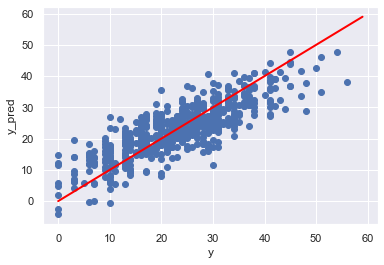

In [42]:
# Plot the predictions

plt.figure()
plt.scatter(y_train,y_pred)
plt.plot(range(60),range(60),linewidth=2, color='red')
plt.xlabel('y')
plt.ylabel('y_pred')
plt.show()

In [43]:
# Use GridSearch to optimize 'Ridge' hyperparameters

param_grid = {'alpha':[0.005, 0.01, 0.05, 0.1, 0.5, 1]}
tscv = TimeSeriesSplit(n_splits=22)

grid = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=tscv)

grid.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=22, test_size=None),
             estimator=Ridge(),
             param_grid={'alpha': [0.005, 0.01, 0.05, 0.1, 0.5, 1]})

In [44]:
# Print optimal hyperparameter value

print(f'Best hyperparameter values for the model is: {grid.best_params_}')

Best hyperparameter values for the model is: {'alpha': 1}


In [45]:
# Predict 'y' using cross-validated data

ridge = Ridge(alpha=1)
ridge.fit(X_train,y_train)
y_pred_cv = ridge.predict(X_train)
print(f'mean squared error:{mean_squared_error(y_train,y_pred_cv)}')

mean squared error:34.73621247012391


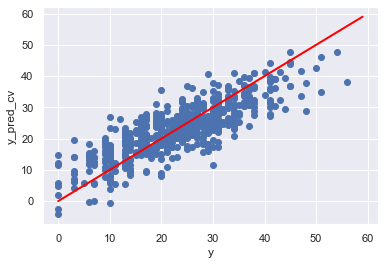

In [46]:
# Plot the predictions

plt.figure()
plt.scatter(y_train,y_pred_cv)
plt.xlabel('y')
plt.plot(range(60),range(60),linewidth=2, color='red')
plt.ylabel('y_pred_cv')
plt.show()

## 3.3. Predict the scores

Now that we have performance estimates of both teams, let's input these values in the team statistics data frame.

In [47]:
# Reset index of X_test data frame

X_test.reset_index(drop=True, inplace=True)
X_test

,Week,Overtime,Home_game,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,...,New Orleans Saints,New York Giants,New York Jets,Philadelphia Eagles,Pittsburgh Steelers,San Francisco 49ers,Seattle Seahawks,Tampa Bay Buccaneers,Tennessee Titans,Washington Football Team
0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
X_test[X_test['Los Angeles Rams'] == 1]

,Week,Overtime,Home_game,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,...,New Orleans Saints,New York Giants,New York Jets,Philadelphia Eagles,Pittsburgh Steelers,San Francisco 49ers,Seattle Seahawks,Tampa Bay Buccaneers,Tennessee Titans,Washington Football Team
0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# Drop 'Week' and add the Rams' and Bengals' performances to the data frame

X_test.drop(columns='Week',inplace=True)
X_test.iloc[0,2:10] = LAR_performance
X_test.iloc[1,2:10] = CIN_performance

In [50]:
# Since the game is played at Los Angeles, it should be considered a home game for the Rams

X_test.iloc[0,1] = 1

In [51]:
X_test

,Overtime,Home_game,1st_downs,Total_yards,Rushing_yards,Turnovers,Opp_1st_downs,Opp_Total_yards,Opp_Rushing_yards,Opp_Turnovers,...,New Orleans Saints,New York Giants,New York Jets,Philadelphia Eagles,Pittsburgh Steelers,San Francisco 49ers,Seattle Seahawks,Tampa Bay Buccaneers,Tennessee Titans,Washington Football Team
0,0.0,1.0,21.25,380.0,114.50,1.75,20.75,364.5,74.75,0.5,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,17.00,285.5,50.75,1.50,24.25,427.5,95.00,2.0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
# Standardize the inputs

X_test_scaled = scaler.transform(X_test.iloc[:,2:10])
X_test.iloc[:,2:10] = X_test_scaled

In [53]:
# Predict the scores

y_pred = ridge.predict(X_test)
y_pred

array([25.75836197, 22.56593422])

**The model predicts that the Los Angeles Rams beat the Cincinnati Bengals 26-23!!**

**Comments:**

This predicted score was reasonably close to the actual one. However, several pieces of important information were missing from the analysis.

1. Special teams' performance - kicker and punter statistics, punt return statistics, field goal kicker accuracy, etc.
2. Defensive performance - Sacks per game.
3. Penalties - penalties can have a huge impact on the game, which we have ignored in this analysis.